In [1]:
# Импортируем библиотеки

import pandas as pd
import numpy as np
import pandahouse as ph
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Определяем функцию для расчета global ctr

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


In [3]:
# Вытаскиваем данные из clickhouse для групп 1 и 2 в период с 2023-01-31 по 2023-02-06

connection = {
              'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20230220',
              'user':'student', 
              'password':'dpo_python_2020'
              }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""


df = ph.read_clickhouse(q, connection=connection)


In [4]:
# Производим расчет global ctr

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

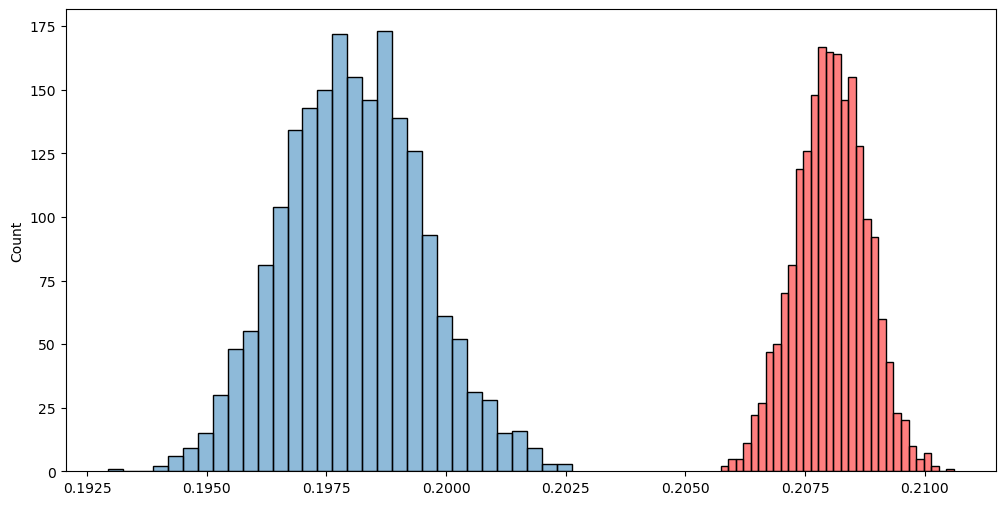

In [5]:
# Рисуем гистограмму распределения global ctr

plt.figure(figsize=(12, 6))
sns.histplot(ctr1, color='red', alpha=0.5)
sns.histplot(ctr2, alpha=0.5)

<AxesSubplot:ylabel='Count'>

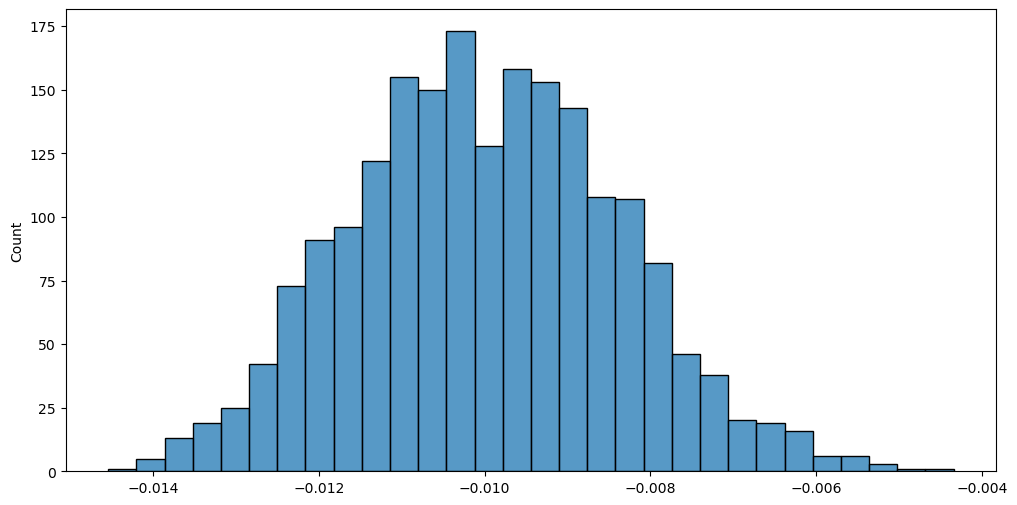

In [6]:
# Рисуем гистограмму разниц между глобальными CTR

plt.figure(figsize=(12, 6))
sns.histplot(ctr2 - ctr1)
